# Using Image Embeddings

FiftyOne provides a powerful [embeddings visualization](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) capability that you can use to generate low-dimensional representations of the samples and objects in your datasets.

This notebook highlights several applications of visualizing image embeddings, with the goal of motivating some of the many possible workflows that you can perform.

Specifically, we'll cover the following concepts:

- Loading datasets from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo_datasets.html)
- Using [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) to generate 2D representations of images
- Providing custom embeddings to [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization)
- Visualizing embeddings via [interactive plots](https://voxel51.com/docs/fiftyone/user_guide/plots.html) connected to the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html)

And we'll demonstrate how to use embeddings to:

- Identify anomolous/incorrect image labels
- Find examples of scenarios of interest
- Pre-annotate unlabeled data for training

**So, what's the takeaway?**

Combing through individual images in a dataset and staring at aggregate performance metrics trying to figure out how to improve the performance of a model is an ineffective and time-consuming process. Visualizing your dataset in a low-dimensional embedding space is a powerful workflow that can reveal patterns and clusters in your data that can answer important questions about the critical failure modes of your model and how to augment your dataset to address these failures.

Using the FiftyOne Brain's [embeddings visualization](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) capability on your ML projects can help you uncover hidden patterns in your data and take action to improve the quality of your datasets and models.

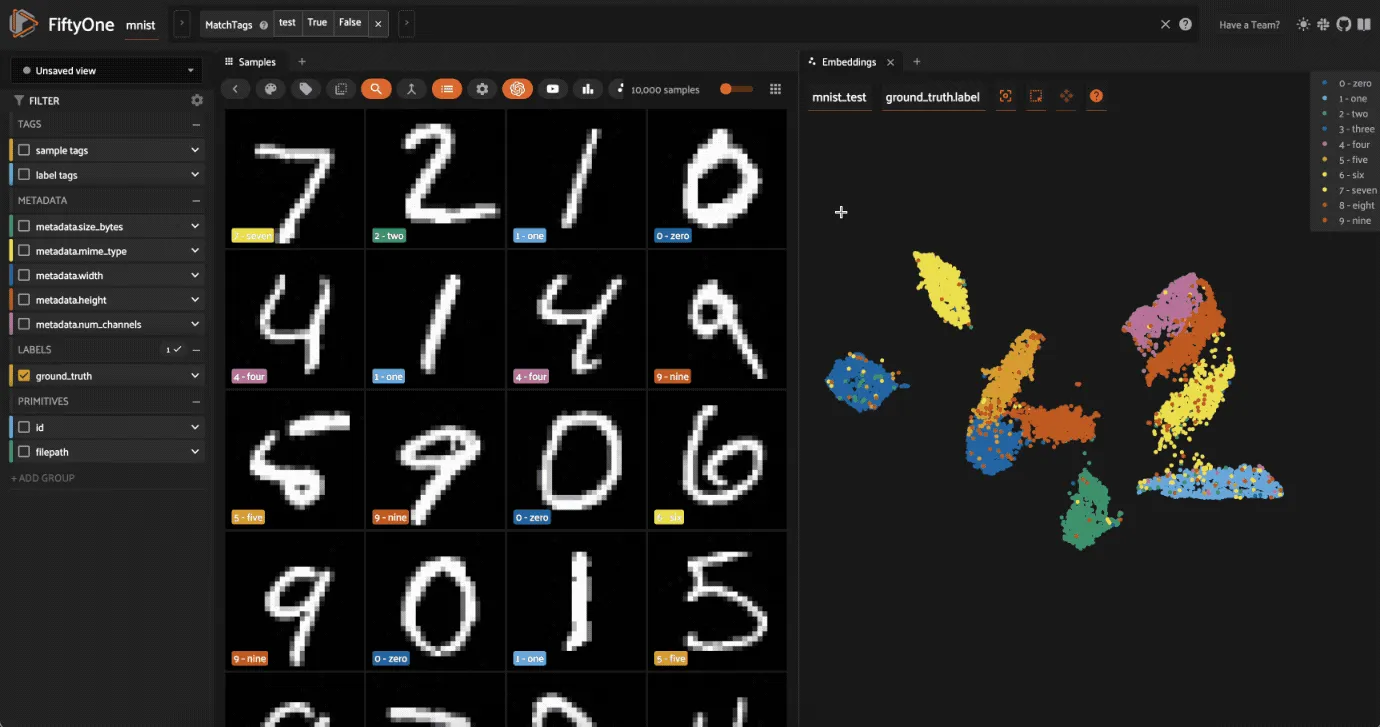

## Setup

If you haven’t already, install FiftyOne:

In [ ]:
!pip install fiftyone

In this tutorial, we'll use some PyTorch models to generate embeddings, and we'll use the (default) [UMAP method](https://github.com/lmcinnes/umap) to generate embeddings, so we'll need to install the corresponding packages:

In [ ]:
!pip install torch torchvision umap-learn

This tutorial will demonstrate the powerful [interactive plotting](https://voxel51.com/docs/fiftyone/user_guide/plots.html) capabilities of FiftyOne. In the FiftyOne App, you can bidirectionally interact with plots to identify interesting subsets of your data and take action on them!

## Part I: MNIST

In this section, we'll be working with the [MNIST dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html?highlight=mnist#dataset-zoo-mnist) from the FiftyOne Dataset Zoo.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("mnist")

Split 'train' already downloaded
Split 'test' already downloaded
Loading existing dataset 'mnist'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


To start, we'll just use the $10,000$ test images from the dataset.

In [8]:
test_split = dataset.match_tags("test")

In [10]:
print(test_split)

Dataset:     mnist
Media type:  image
Num samples: 10000
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tags=['test'], bool=True, all=False)


### Computing image embeddings

Typically when generating low-dimensional representations of image datasets, one will use a deep model to generate embeddings for each image, say 1024 or 2028 dimensional, that are then passed to a dimensionality reduction method like [UMAP](https://github.com/lmcinnes/umap) or [t-SNE](https://lvdmaaten.github.io/tsne) to generate the 2D or 3D representation that is visualized.

Such an intermediate embedding step is necessary when the images in the dataset have different sizes, or are too large for [UMAP](https://github.com/lmcinnes/umap) or [t-SNE](https://lvdmaaten.github.io/tsne) to directly process, or the dataset is too complex and a model trained to recognize the concepts of interest is required in order to produce interpretable embeddings.

However, for a relatively small and fixed size dataset such as MNIST, we can pass the images themselves to the dimensionality reduction method.

Let's use the [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) method to generate our first representation:

In [11]:
import cv2
import numpy as np

import fiftyone.brain as fob

# Construct a ``num_samples x num_pixels`` array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in test_split.values("filepath")
])

# Compute 2D representation
results = fob.compute_visualization(
    test_split,
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    brain_key="mnist_test",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(random_state=51, verbose=True)
Wed Mar 27 11:27:43 2024 Construct fuzzy simplicial set
Wed Mar 27 11:27:43 2024 Finding Nearest Neighbors
Wed Mar 27 11:27:43 2024 Building RP forest with 10 trees
Wed Mar 27 11:27:43 2024 NN descent for 13 iterations
	 1  /  13


/opt/homebrew/Caskroom/miniforge/base/envs/fo-dev/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Wed Mar 27 11:27:43 2024 Finished Nearest Neighbor Search
Wed Mar 27 11:27:43 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Mar 27 11:27:56 2024 Finished embedding


The method returned a `results` object with a `points` attribute that contains a `10000 x 2` array of 2D embeddings for our samples that we'll visualize next.

In [12]:
print(type(results))
print(results.points.shape)

<class 'fiftyone.brain.visualization.VisualizationResults'>
(10000, 2)


If you ever want to access this results object again from the dataset, you can do so with the dataset's `load_brain_results()` method, passing the `brain_key` that you used to store the results:

In [13]:
dataset.load_brain_results("mnist_test")

### Visualization parameters

There are two primary components to an embedding visualization: the method used to generate the embeddings, and the dimensionality reduction method used to compute a low-dimensional representation of the embeddings.

The ``embeddings`` and ``model`` parameters of
[compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) support a variety of ways to generate embeddings for your data:

- Provide nothing, in which case a default general-purpose model is used to embed your data
- Provide a [Model instance](https://voxel51.com/docs/fiftyone/api/fiftyone.core.models.html#fiftyone.core.models.Model) or the name of any model from the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) that supports embeddings
- Compute your own embeddings and provide them as an array
- Specify the name of a field of your dataset in which embeddings are stored

The ``method`` parameter of [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) allows you to specify the dimensionality reduction method to use. The supported methods are:

- `"umap"` **(default)**: Uniform Manifold Approximation and Projection ([UMAP](https://github.com/lmcinnes/umap))
- `"t-sne"`: t-distributed Stochastic Neighbor Embedding ([t-SNE](https://lvdmaaten.github.io/tsne))
- `"pca"`: Principal Component Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))

### Visualizing embeddings

Now we're ready to use [results.visualize()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.VisualizationResults.visualize) to visualize our representation.

Although we could use this method in isolation, the real power of FiftyOne comes when you [attach plots to the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots), so that when points of interest are selected in the plot, the corresponding samples are automatically selected in the App, and vice versa.

So, let's open the test split in the App:

In [ ]:
# Launch App instance
session = fo.launch_app(test_split)

![MNIST test split](images/image_embeddings_test_split.webp)

Now let's visualize the results in the [Embeddings Panel](https://docs.voxel51.com/user_guide/app.html#embeddings-panel) in the FiftyOne App, and color by ground truth label:

![MNIST embeddings](images/image_embeddings_panel.webp)

Notice that the scatterpoints are naturally clustered by color (ground truth label), which means that [UMAP](https://github.com/lmcinnes/umap) was able to capture the visual differences between the digits!

### Scatterplot controls

Now it's time to explore the scatterplot interactively. In the top of the panel, you will see controls that allow you to do the following:
- The `Zoom`, `Pan`, `Zoom In`, `Zoom Out`, `Autoscale`, and `Reset axes` modes can be used to manipulate your current view
- The `Box Select` and `Lasso Select` modes enable you to select points in the plot

In `Box Select` or `Lasso Select` mode, drawing on the plot will select the points within the region you define. In addition, note that you can:
- Hold shift to add a region to your selection
- Double-click anywhere on the plot to deselect all points

Since we chose a categorical label for the points, each ground truth label is given its own trace in the legend on the righthand side. You can interact with this legend to show/hide data:
- Single-click on a trace to show/hide all points in that trace
- Double-click on a trace to show/hide all *other* traces

### Exploring the embeddings

Here's a couple suggestions for exploring the data:

- Use `Lasso Select` to select the cluster of points corresponding to the `0` label. Note that the corresponding images loaded in the App are all images of zeros, as expected
- Try selecting other clusters and viewing the images in the App
- Click on the `0` label in the legend to hide the zeros. Now lasso the points from other traces that are in the `0` cluster. These are non-zero images in the dataset that are likley to be confused as zeros!

![likely zero confusions](images/image_embeddings_zero_cluster.webp)

Now try double-clicking on the `0` legend entry so that only the `0` points are visible in the plot. Then use the `Lasso Select` to select the `0` points that are far away from the main `0` cluster. These are zero images in the dataset that are likely to be confused as non-zeroes by a model!

![likely nonzero confusions](images/image_embeddings_nonzero_cluster.webp)

Cool, right? It is clear that [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) has picked up on some interesting structure in the test split of the dataset.

### Pre-annotation of samples

Now let's put the insights from the previous section to work.

Imagine that you are [Yann LeCun](http://yann.lecun.com) or [Corinna Cortes](https://research.google/people/author121/), the creators of the MNIST dataset, and you have just invested the time to annotate the test split of the dataset by hand. Now, you have collected an additional 60K images of unlabeled digits that you want to use as a training split that you need to annotate.

Let's see how [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) can be used to efficiently pre-annotate the train split with minimal effort.

First, let's regenerate embeddings for all 70,000 images in the combined test and train splits:

In [8]:
# Construct a ``num_samples x num_pixels`` array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in dataset.values("filepath")
])

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    brain_key="mnist",
    verbose=True,
    seed=51,
)

Generating visualization...


/opt/homebrew/Caskroom/miniforge/base/envs/fo-dev/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/fo-dev/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=51, verbose=True)
Wed Mar 27 11:37:27 2024 Construct fuzzy simplicial set
Wed Mar 27 11:37:27 2024 Finding Nearest Neighbors
Wed Mar 27 11:37:27 2024 Building RP forest with 18 trees
Wed Mar 27 11:37:30 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Mar 27 11:37:38 2024 Finished Nearest Neighbor Search
Wed Mar 27 11:37:40 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Mar 27 11:38:12 2024 Finished embedding


Of course, our dataset already has ground truth labels for the train split, but let's pretend that's not the case and generate an array of `labels` for our visualization that colors the test split by its ground truth labels and marks all images in the train split as `unlabeled`:

In [9]:
from fiftyone import ViewField as F

# Label `test` split samples by their ground truth label
# Mark all samples in `train` split as `unlabeled`
expr = F("$tags").contains("test").if_else(F("label"), "unlabeled")
labels = dataset.values("ground_truth", expr=expr)
# Set the `ground_truth.label` field to the computed labels
dataset.set_values("ground_truth.label", labels)

In [ ]:
# Launch a new App instance
session = fo.launch_app(dataset, auto=False)

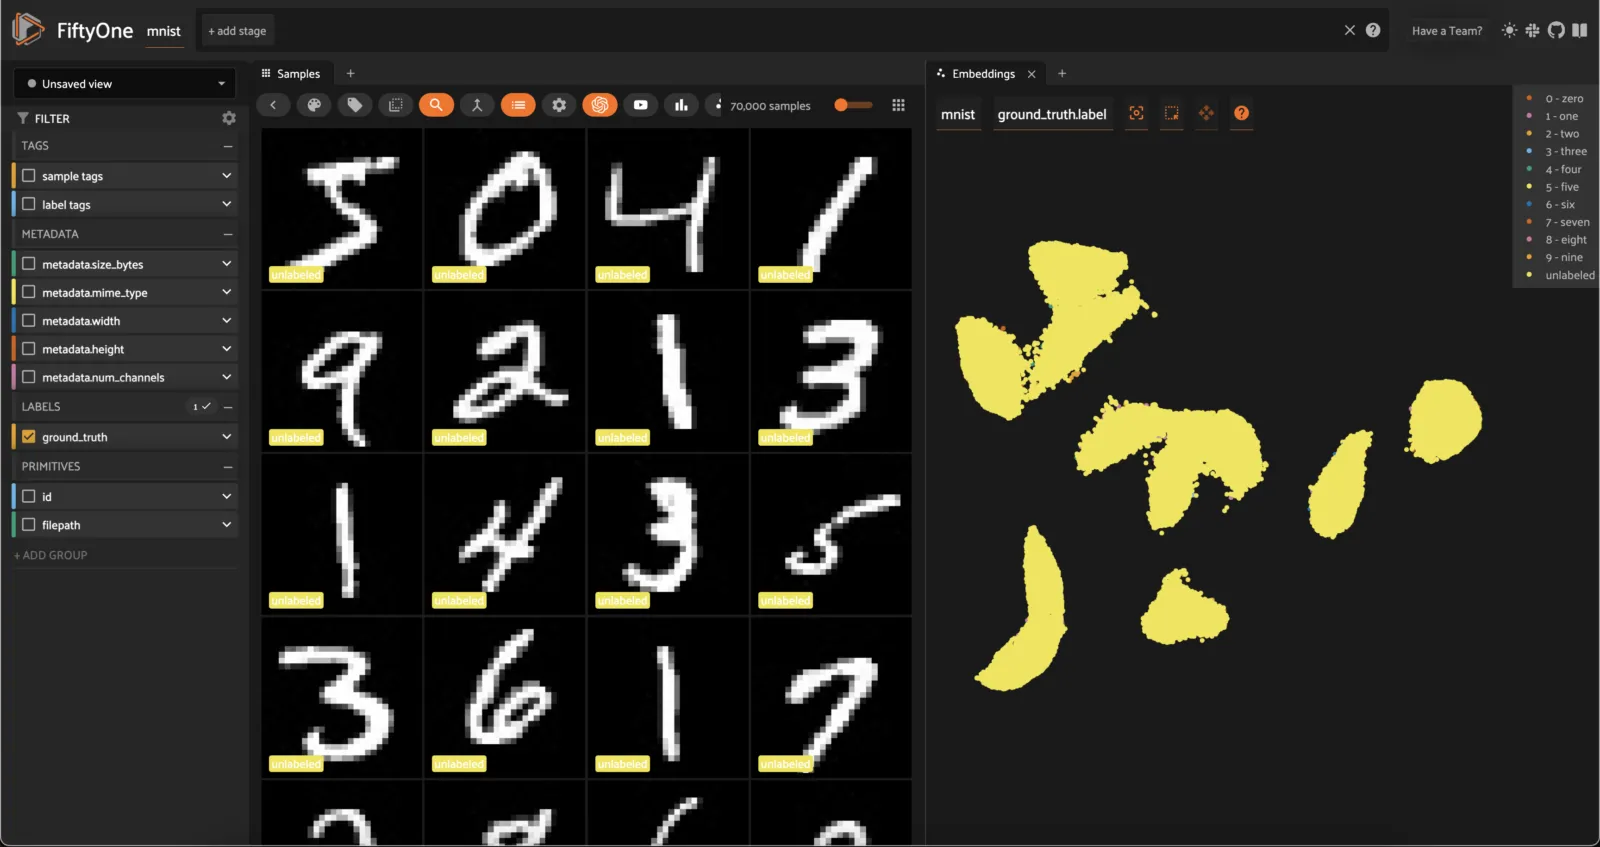

What's so great about this plot? Notice that the unlabeled points in our (to-be-labeled) train split are heavily clustered into the same clusters as the labeled points from the test split!

Follow the simple workflow below to use FiftyOne's [in-App tagging feature](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging) to efficiently assign proposed labels for all samples in the `train` split:
1. Click on the `unlabeled` trace to hide it, and then use the predominant color of the labeled points in the cluster below to determine the identity of the cluster
2. Now double-click on the `unlabeled` trace so that *only* the unlabeled points are visible in the plot
3. Use the `Lasso Select` tool to select the `unlabeled` points in the cluster whose identity you just deduced
4. Over in the App, click on the `tag` icon and assign a tag to the samples 
5. Repeat steps 1-4 for the other clusters

Congratulations, you just pre-annotated ~60,000 training images! 

![pre-annotation](images/image_embeddings_prelabel.webp)

You can easily print some statistics about the sample tags that you created:

In [12]:
# The train split that we pre-annotated
train_split = dataset.match_tags("train")

# Print state about labels that were added
print(train_split.count_sample_tags())

{'8': 5577, '6': 6006, '3': 6104, '7': 6361, '9': 6036, '5': 5389, 'train': 60000, '0': 5981, '4': 5737, '2': 5811, '1': 6937}


The snippet below converts the sample tags into [Classification labels](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#classification) in a new ``hypothesis`` field of the dataset:

In [21]:
# Add a new Classification field called `hypothesis` to store our guesses
with fo.ProgressBar() as pb:
    for sample in pb(train_split):
        labels = [t for t in sample.tags if t != "train"]
        if labels:
            sample["hypothesis"] = fo.Classification(label=labels[0])
            sample.save()

# Print stats about the labels we created
print(train_split.count_values("hypothesis.label"))

 100% |█████████████| 60000/60000 [2.6m elapsed, 0s remaining, 353.0 samples/s]      
{'0': 5981, '9': 6036, '8': 5572, '7': 6361, '6': 6006, '5': 5388, None: 69, '3': 6104, '1': 6937, '4': 5735, '2': 5811}


In the example above, notice that 69 samples in the train split were not given a hypothesis (i.e., they were not included in the cluster-based tagging procedure). If you would like to retrieve them and manually assign tags, that is easy:

In [23]:
no_hypothesis = train_split.exists("hypothesis.label", False)
print(no_hypothesis)

Dataset:        mnist
Media type:     image
Num samples:    69
Tags:           ['train']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    hypothesis:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tags=['train'])
    2. Exists(field='hypothesis.label', bool=False)


Depending on your application, you may be able to start training using the `hypothesis` labels directly by [exporting the dataset](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html) as, say, a classification directory tree structure:

In [ ]:
# Export `hypothesis` labels as a classification directory tree format
# `exists()` ensures that we only export samples with a hypothesis
train_split.exists("hypothesis.label").export(
    export_dir="/path/for/dataset",
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field="hypothesis",
)

Or perhaps you'll want to export the hypothesized labels to your annotation provider to fine-tune the labels for training.

FiftyOne provides integrations for importing/exporting data to [Scale](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html), [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html), [Label Studio](https://docs.voxel51.com/integrations/labelstudio.html), [V7](https://docs.voxel51.com/integrations/v7.html), and [CVAT](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html#cvatimagedataset). Check out [this blog post](https://towardsdatascience.com/managing-annotation-mistakes-with-fiftyone-and-labelbox-fc6e87b51102) for more information about FiftyOne's Labelbox integration.

### Loading existing visualizations

If you provide the `brain_key` argument to [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization), then the visualization results that you generate will be saved and you can recall them later.

For example, we can recall the visualization results that we first computed on the test split:

In [60]:
# List brain runs saved on the dataset
print(dataset.list_brain_runs())

# Load the results for a brain run
results = dataset.load_brain_results("mnist_test")
print(type(results))

# Load the dataset view on which the results were computed
results_view = dataset.load_brain_view("mnist_test")
print(len(results_view))

['mnist', 'mnist_test']
<class 'fiftyone.brain.visualization.VisualizationResults'>
10000


See [this docs page](https://voxel51.com/docs/fiftyone/user_guide/brain.html#managing-brain-runs) for more information about managing brain runs.

## Part II: BDD100K

In this section, we'll visualize embeddings from a deep model on the [BDD100K dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html?highlight=bdd100k#dataset-zoo-bdd100k) from the FiftyOne Dataset Zoo and demonstrate some of the insights that you can glean from them.

If you want to follow along youself, you will need to register at https://bdd-data.berkeley.edu in order to get links to download the data. See the [zoo docs](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html?highlight=bdd100k#dataset-zoo-bdd100k) for details on loading the dataset.

We'll be working with the validation split, which contains 10,000 labeled images:

In [25]:
import fiftyone as fo
import fiftyone.zoo as foz

# The path to the source files that you manually downloaded
source_dir = "/path/to/dir-with-bdd100k-files"

dataset = foz.load_zoo_dataset("bdd100k", split="validation", source_dir=source_dir)

Split 'validation' already prepared
Loading existing dataset 'bdd100k-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
session = fo.launch_app(dataset)

![BDD100K validation split](images/image_embeddings_bdd100k.webp)

### Computing image embeddings

The BDD100K images are 1280 x 720 pixels, so we'll use a deep model to generate intermediate embeddings.

Using a deep model not only enables us to visualize larger datasets or ones with different image sizes, it also enables us to key in on different features of the dataset, depending on the model that we use to generate embeddings. By default, [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization) will generate embeddings using a general-purpose model that works well for datasets of any kind.

You can run the cell below to generate a 2D representation for the BDD100K validation split using FiftyOne's default model. You will likely want to run this on a machine with GPU, as this requires running inference on 10,000 images:

In [ ]:
import fiftyone.brain as fob

# Compute 2D representation
# This will compute deep embeddings for all 10,000 images
results = fob.compute_visualization(
    dataset,
    num_dims=2,
    brain_key="img_viz",
    verbose=True,
    seed=51,
)

Alternatively, you can provide your own custom embeddings via the `embeddings` parameter of [compute_visualization()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.html#fiftyone.brain.compute_visualization). The [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) provides dozens of models that expose embeddings that you can use for this purpose.

For example, the cell below generates a visualization using pre-computed embeddings from a ResNet model from the zoo:

In [ ]:
# Load a resnet from the model zoo
model = foz.load_zoo_model("resnet50-imagenet-torch")

# Verify that the model exposes embeddings
print(model.has_embeddings)
# True

# Compute embeddings for each image
embeddings = dataset.compute_embeddings(model)
print(embeddings.shape)
# 10000 x 2048

# Compute 2D representation using pre-computed embeddings
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    brain_key="image_embeddings",
    verbose=True,
    seed=51,
)

Either way, we're ready to visualize our representation.

### Visualizing embeddings

As usual, we'll start by launching an App instance and opening the embeddings panel to interactively explore the results:

In [ ]:
session = fo.launch_app(dataset)

The BDD100K dataset contains a handful of image-level labels, including scene type, time of day, and weather.

Let's use the time of day labels to color our scatterplot:

![BDD100K embeddings](images/image_embeddings_bdd100k_colorby.webp)

Notice that the visualization has a dominant bimodal distribution corresponding to whether the time of day is `daytime` or `night`!

You can investigate each cluster in more detail using the `Zoom` and `Pan` controls of the plot's modebar.

### Investigating outliers

Outlier clusters in these plots often correspond to images with distinctive properties. Let's `Lasso Select` some outlier regions to investigate:

- The first cluster contains images where the dashboard of the vehicle heavily occludes the view
- The second cluster contains images in rainy scenes where the windshield has water droplets on it
- The third cluster contains images where a cell phone is in the field of view

![bdd100k-outliers](images/image_embeddings_outliers.webp)

### Tagging label mistakes

We can also use the scatterplot to tag samples whose `timeofday` labels are incorrect by taking the following actions:

- Deselect all labels except `night` in the legend
- Lasso select the nightime points (yellow) within the daytime cluster (red)
- Click the tag icon in the upper-left corner of the sample grid in the App
- Add an appropriate tag to the samples in the current view to mark the mistakes

![bdd100k-mistakes](images/image_embeddings_tag_mistakes.webp)

## Summary

In this tutorial, we showed how to use FiftyOne to compute embeddings for image datasets and demonstrated a few of their many uses, including:

- Visualizing the hidden structure of image datasets
- Pre-annotating unlabeled data for training
- Identifying anomolous/incorrect image labels
- Finding examples of scenarios of interest

**So, what's the takeaway?**

Combing through individual images in a dataset and staring at aggregate performance metrics trying to figure out how to improve the performance of a model is an ineffective and time-consuming process.

Visualizing your dataset in a low-dimensional embedding space is a powerful workflow that can reveal patterns and clusters in your data that can answer important questions about the critical failure modes of your model. It can also help you automate workflows like finding label mistakes and efficiently pre-annotating data.

FiftyOne also supports visualizing embeddings for object detections. Stay tuned for an upcoming tutorial on the topic!